<a href="https://colab.research.google.com/github/naman-mehta/predict_steering_angle/blob/master/selfdriving.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow import keras

import pathlib
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Mounting Google Drive locally.** 
I have downloaded the SullyChen's auto pilot dataset from https://github.com/SullyChen/driving-datasets and got it uploaded back unzipped in my google drive.

In [0]:
#path to drive /content/drive/My Drive/self_driving
data_dir="/content/drive/My Drive/self_driving/"
with open( data_dir+'smallset.txt', 'r') as f:
  contents=f.read()
  
contents= list(contents.split('\n'))  
del contents[-1]



#print(contents)
#contents[0].split()[1].split(',')[0]




In [0]:
import numpy as np
import matplotlib.pyplot as plt
import math


In [4]:
len(contents)


1280

In [5]:
contents1 = tf.data.Dataset.from_tensor_slices(contents)
contents1.element_spec

for line in contents1.take(1):
  print(line)
  x=tf.strings.split(tf.strings.split(line, ',')[0],' ')[1]
  y=tf.strings.to_number(x)
  pi_on_180 = 0.017453292519943295
  a=tf.math.multiply(y,pi_on_180)
  
a
#x=tf.strings.split(tf.strings.split(contents2, ',')[0],' ')[1]



tf.Tensor(b'60000.jpg 12.200000,2018-07-01 18:02:28:11', shape=(), dtype=string)


<tf.Tensor: id=137, shape=(), dtype=float32, numpy=0.21293016>

In [22]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
"""code with tensorflow tf.data.dataset"""
IMG_WIDTH=66
IMG_HEIGHT=200

def get_label(file_path):
  file_path=tf.strings.split(tf.strings.split(file_path, ',')[0],' ')[1]
  label_in_degree=tf.strings.to_number(file_path)
  pi_on_180 = 0.017453292519943295
  return tf.math.multiply(label_in_degree,pi_on_180)

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(data_dir+ tf.strings.split(file_path, ' ')[0])
  img = decode_img(img)
  return img, label

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = contents1.map(process_path,num_parallel_calls=AUTOTUNE)
print(labeled_ds.element_spec)

for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())
  
train = labeled_ds.take(int(len(contents)*0.8))
test = labeled_ds.skip(int(len(contents)*0.8))


(TensorSpec(shape=(66, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))
Image shape:  (66, 200, 3)
Label:  0.21293016


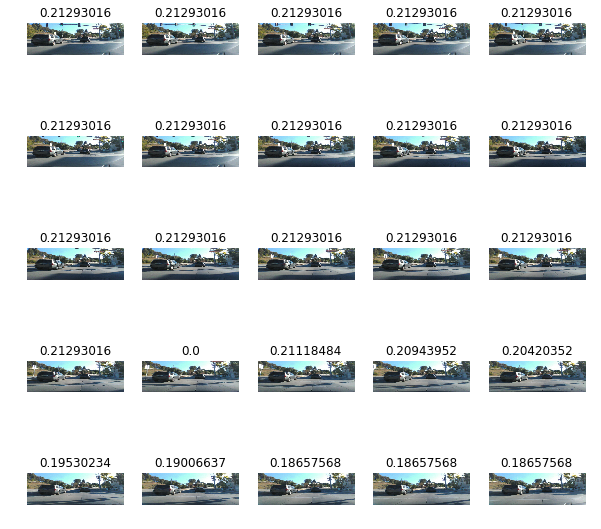

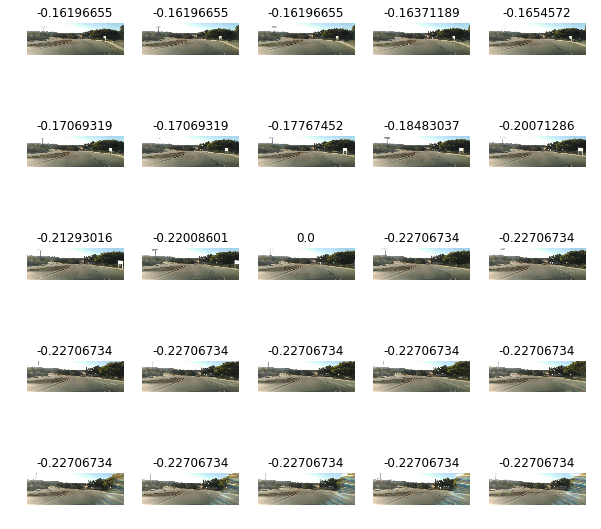

In [23]:
#repeat and batch. Inspect a batch.
EPOCHS = 30
BATCH_SIZE = 100


def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(label_batch[n])
      plt.axis('off')


def prepare_for_training(ds, cache=True):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()
  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

train_ds = prepare_for_training(train)
test_ds = prepare_for_training(test)
print("training dataset")
image_batch, label_batch = next(iter(train_ds))

show_batch(image_batch.numpy(), label_batch.numpy())
print("testing")
image_batch, label_batch = next(iter(test_ds))

show_batch(image_batch.numpy(), label_batch.numpy())



In [0]:
model = Sequential([
    # We have a series of 3 5x5 convolutional layers with a stride of 2x2
    Conv2D(filters=24,kernel_size = 5,strides=(2, 2),activation='relu',input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    BatchNormalization(),

    Conv2D(filters=36,kernel_size = 5,strides=(2, 2),activation='relu'),
    BatchNormalization(),
   
    Conv2D(filters=48,kernel_size = 5,strides=(2, 2),activation='relu'),
    BatchNormalization(),

    
    # This is then followed by 2 3x3 convolutional layers with a 1x1 stride
    
    Conv2D(filters=64,kernel_size = 3,strides=(1, 1),activation='relu'),
    BatchNormalization(),
    
    Conv2D(filters=64,kernel_size = 3,strides=(1, 1),activation='relu'),
    BatchNormalization(),
    
    # Flattening the output of last convolutional layer before entering fully connected phase
    Flatten(),
    
    # Fully connected layers
    Dense(1164, activation='relu'),
    BatchNormalization(),
    
    Dense(200, activation='relu'),
    BatchNormalization(),
    
    Dense(50, activation='relu'),
    BatchNormalization(),
    
    Dense(10, activation='relu'),
    BatchNormalization(),
   
    # Output layer
    Dense(1)
    
])    
    
    
    model.compile(optimizer='adam'learning_rate=0.001,
              loss='mse',
              metrics=['mae', 'mse'])
    
    model.compile(loss = "MSE", optimizer = Adam(lr = 0.001))

In [15]:
# """code with python"""
# IMG_WIDTH=66
# IMG_HEIGHT=200

# def get_label(file_path):
#   #parts = tf.strings.split(file_path, '/')
#   return math.radians(tf.strings.to_number(tf.strings.split(tf.strings.split(file_path, ',')[0],' ')[1]))
#   #return math.radians(float(file_path.split()[1].split(',')[0]))

# def decode_img(img):
#   # convert the compressed string to a 3D uint8 tensor
#   img = tf.image.decode_jpeg(img, channels=3)
#   # Use `convert_image_dtype` to convert to floats in the [0,1] range.
#   img = tf.image.convert_image_dtype(img, tf.float32)
#   # resize the image to the desired size.
#   return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

# def process_path(file_path):
#   label = get_label(file_path)
#   # load the raw data from the file as a string
#   img = tf.io.read_file(data_dir+ file_path.split()[0])
#   img = decode_img(img)
#   return img, label

# # Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
# labeled_ds = contents.map(process_path)
# labeled_ds.element_spec


# labeled_ds = map(process_path,contents)
# #convert map object to list of tuples having (image,label)
# labeled_dataset=list(labeled_ds)
#  image=labeled_dataset[0][0]
# plt.imshow(image.numpy())
# label=labeled_dataset[0][1]
# print("image shape=",image.numpy().shape,"image label=",label,sep="\n")


NameError: ignored

In [0]:
# import scipy.misc
# import random
# import math

# xs = []
# ys = []

# #points to the end of the last batch
# train_batch_pointer = 0
# val_batch_pointer = 0

# #read data.txt
# with open("/content/drive/My Drive/self_driving/smallset.txt") as f:
#     for line in f:
#         xs.append("/content/drive/My Drive/self_driving/" + line.split()[0])
#         ys.append(math.radians(float(line.split()[1].split(',')[0])))

# #get number of images
# num_images = len(xs)


# train_xs = xs[:int(len(xs) * 0.8)]
# train_ys = ys[:int(len(xs) * 0.8)]

# val_xs = xs[-int(len(xs) * 0.2):]
# val_ys = ys[-int(len(xs) * 0.2):]

# num_train_images = len(train_xs)
# num_val_images = len(val_xs)

# def LoadTrainBatch(batch_size):
#     global train_batch_pointer
#     x_out = []
#     y_out = []
#     for i in range(0, batch_size):
#         x_out.append(scipy.misc.imresize(scipy.misc.imread(train_xs[(train_batch_pointer + i) % num_train_images])[-150:], [66, 200]) / 255.0)
#         y_out.append([train_ys[(train_batch_pointer + i) % num_train_images]])
#     train_batch_pointer += batch_size
#     return x_out, y_out

# def LoadValBatch(batch_size):
#     global val_batch_pointer
#     x_out = []
#     y_out = []
#     for i in range(0, batch_size):
#         x_out.append(scipy.misc.imresize(scipy.misc.imread(val_xs[(val_batch_pointer + i) % num_val_images])[-150:], [66, 200]) / 255.0)
#         y_out.append([val_ys[(val_batch_pointer + i) % num_val_images]])
#     val_batch_pointer += batch_size
#     return x_out, y_out


xs[]- list that will contain the path to the image files.

ys[]- list that will be having steering angles converted to radians

Data set is split into 80:20 ratio

The functions used load one batch of training or validation data

The model is based on https://arxiv.org/pdf/1604.07316.pdf
End to End Learning for Self-Driving Cars by Nvidia

In [0]:
!pip install tensorflow==1.12.0
import tensorflow as tf
print(tf.__version__)
import scipy

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W, stride):
  return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='VALID')

x = tf.placeholder(tf.float32, shape=[None, 66, 200, 3])
y_ = tf.placeholder(tf.float32, shape=[None, 1])

x_image = x

#first convolutional layer
W_conv1 = weight_variable([5, 5, 3, 24])
b_conv1 = bias_variable([24])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1, 2) + b_conv1)

#second convolutional layer
W_conv2 = weight_variable([5, 5, 24, 36])
b_conv2 = bias_variable([36])

h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2, 2) + b_conv2)

#third convolutional layer
W_conv3 = weight_variable([5, 5, 36, 48])
b_conv3 = bias_variable([48])

h_conv3 = tf.nn.relu(conv2d(h_conv2, W_conv3, 2) + b_conv3)

#fourth convolutional layer
W_conv4 = weight_variable([3, 3, 48, 64])
b_conv4 = bias_variable([64])

h_conv4 = tf.nn.relu(conv2d(h_conv3, W_conv4, 1) + b_conv4)

#fifth convolutional layer
W_conv5 = weight_variable([3, 3, 64, 64])
b_conv5 = bias_variable([64])

h_conv5 = tf.nn.relu(conv2d(h_conv4, W_conv5, 1) + b_conv5)

#FCL 1
W_fc1 = weight_variable([1152, 1164])
b_fc1 = bias_variable([1164])

h_conv5_flat = tf.reshape(h_conv5, [-1, 1152])
h_fc1 = tf.nn.relu(tf.matmul(h_conv5_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

#FCL 2
W_fc2 = weight_variable([1164, 100])
b_fc2 = bias_variable([100])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

#FCL 3
W_fc3 = weight_variable([100, 50])
b_fc3 = bias_variable([50])

h_fc3 = tf.nn.relu(tf.matmul(h_fc2_drop, W_fc3) + b_fc3)

h_fc3_drop = tf.nn.dropout(h_fc3, keep_prob)

#FCL 3
W_fc4 = weight_variable([50, 10])
b_fc4 = bias_variable([10])

h_fc4 = tf.nn.relu(tf.matmul(h_fc3_drop, W_fc4) + b_fc4)

h_fc4_drop = tf.nn.dropout(h_fc4, keep_prob)

#Output
W_fc5 = weight_variable([10, 1])
b_fc5 = bias_variable([1])

y = tf.multiply(tf.atan(tf.matmul(h_fc4_drop, W_fc5) + b_fc5), 2) #scale the atan output

In [0]:
import os
import tensorflow as tf
from tensorflow.core.protobuf import saver_pb2


LOGDIR = './save'

sess = tf.InteractiveSession()

L2NormConst = 0.001

train_vars = tf.trainable_variables()

loss = tf.reduce_mean(tf.square(tf.subtract(y_, y))) + tf.add_n([tf.nn.l2_loss(v) for v in train_vars]) * L2NormConst
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)
sess.run(tf.initialize_all_variables())

# create a summary to monitor cost tensor
tf.summary.scalar("loss", loss)
# merge all summaries into a single op
merged_summary_op =  tf.summary.merge_all()

saver = tf.train.Saver(write_version = saver_pb2.SaverDef.V1)

# op to write logs to Tensorboard
logs_path = './logs'
summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

epochs = 30
batch_size = 100

# train over the dataset about 30 times
for epoch in range(epochs):
  for i in range(int(num_images/batch_size)):
    xs, ys = LoadTrainBatch(batch_size)
    train_step.run(feed_dict={x: xs, y_: ys,keep_prob: 0.8})
    if i % 10 == 0:
      xs, ys = LoadValBatch(batch_size)
      loss_value = loss.eval(feed_dict={x:xs, y_: ys, keep_prob: 1.0})
      print("Epoch: %d, Step: %d, Loss: %g" % (epoch, epoch * batch_size + i, loss_value))

    # write logs at every iteration
    summary = merged_summary_op.eval(feed_dict={x:xs,y_: ys,keep_prob: 1.0})
    summary_writer.add_summary(summary, epoch * num_images/batch_size + i)

    if i % batch_size == 0:
      if not os.path.exists(LOGDIR):
        os.makedirs(LOGDIR)
      checkpoint_path = os.path.join(LOGDIR, "model.ckpt")
      filename = saver.save(sess, checkpoint_path)
  print("Model saved in file: %s" % filename)
